In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from sklearn import tree
from skmultilearn.problem_transform import LabelPowerset
from sklearn.tree import DecisionTreeClassifier, plot_tree, _tree
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import make_multilabel_classification
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, Lasso, LassoCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from xgboost import XGBRegressor, plot_importance



## Decision Trees as Interpretable Models

Get the Accute Inflammations Data Set from https://archive.ics.uci.edu/dataset/184/acute+inflammations

In [3]:
diagnosis_cols = [
    "temp", # a1 Temperature of patient { 35C-42C }
    "nausea", # a2 Occurrence of nausea { yes, no }
    "lumbar pain", # a3 Lumbar pain { yes, no }
    "urine pushing", # a4 Urine pushing (continuous need for urination) { yes, no }
    "micturition pains", # a5 Micturition pains { yes, no }
    "urethra pain", # a6 Burning of urethra, itch, swelling of urethra outlet { yes, no }
    "inflammation", # d1 decision: Inflammation of urinary bladder { yes, no }
    "nephritis" # d2 decision: Nephritis of renal pelvis origin { yes, no } 
]


# create df
diagnosis_df = pd.read_csv("data/diagnosis.data", sep=r"\s+", names=diagnosis_cols, encoding='utf-16')

# replace comma with period in temp and convert to float - helps with analysis
diagnosis_df["temp"] = (
    diagnosis_df["temp"]
    .astype(str)
    .str.replace(r"(\d+),(\d+)", r"\1.\2", regex=True)
    .astype(float)
)

# convert categorical features to numerical representations 
# yes = 1 // no = 0
cat_cols = diagnosis_cols[1:]
for col in cat_cols:
    diagnosis_df[col] = diagnosis_df[col].apply(lambda a: 1 if a == "yes" else 0)

#print(diagnosis_df)

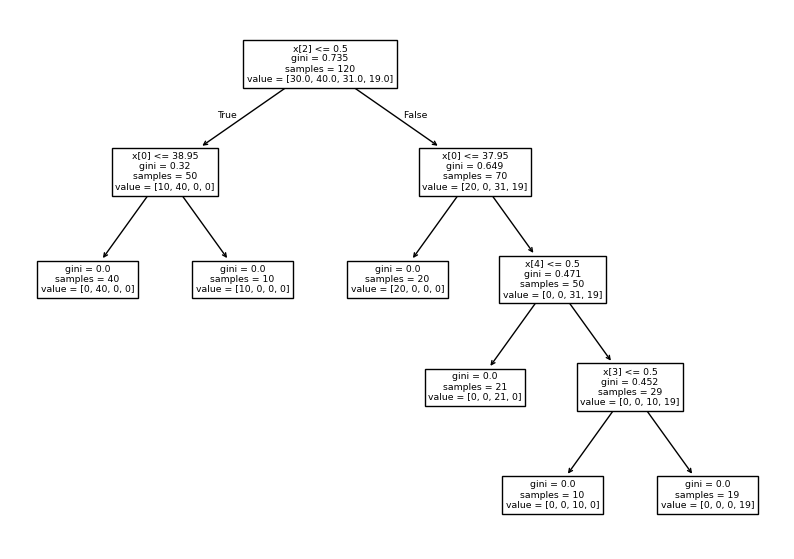

None


In [4]:
# decisions - inflammation, nephritis -- can be inflammation, nephritis, both or none
# multiclass- each instance belongs to one class, mutually exclusive
# multilabel- each instance can belong to multiple classes, not mutually exclusive

# label powerset converts to multiclass by treating each unique combination of labels as its own class
    # both inflammation and nephritis (1,1)
    # neither inflammation or nephritis (0,0)
    # only inflammation (1,0)
    # only nephritis (0,1)

# yes = 1 // no = 0

tree_features = ["temp", "nausea", "lumbar pain", "urine pushing", "micturition pains", "urethra pain"]
tree_labels = ["inflammation", "nephritis"]

# build tree using Label Powerset
def build_decision_tree(df, x_vars, labels):
    # ID X and y vars and converty to numpy array
    X_train = df[x_vars].to_numpy()
    y_train = df[labels].to_numpy()

    # initialize and train LabelPowerset multi-label classifier with a decision tree
    model = tree.DecisionTreeClassifier(random_state=13)
    clf = LabelPowerset(classifier=model)
    clf.fit(X_train, y_train)

    return clf

# decision tree visualization
def plot_tree(model):
    # gini index - measure of purity
    # measures the probability of a randomly chosen element being incorrectly classified
    # lower Gini index values indicates that a node contains predocinantly observations from single class
    plt.figure(figsize=(10, 7))
    tree.plot_tree(model.classifier)
    plt.show()

model = build_decision_tree(diagnosis_df, tree_features, tree_labels)
print(plot_tree(model))

**Convert the decision rules into a set of IF-THEN rules using code from** 
https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html


In [4]:
# function from kd nuggets website 
# write psuedocode for a decision tree
def tree_to_code(tree_model, x_vars):

	# recurse(left, right, threshold, features, 0)
	tree_ = tree_model.classifier.tree_
	feature_name = [
		x_vars[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(x_vars)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

# call psuedocode function
tree_to_code(model, tree_features)

def tree(temp, nausea, lumbar pain, urine pushing, micturition pains, urethra pain):
  if lumbar pain <= 0.5:
    if temp <= 38.95000076293945:
      return [[0. 1. 0. 0.]]
    else:  # if temp > 38.95000076293945
      return [[1. 0. 0. 0.]]
  else:  # if lumbar pain > 0.5
    if temp <= 37.95000076293945:
      return [[1. 0. 0. 0.]]
    else:  # if temp > 37.95000076293945
      if micturition pains <= 0.5:
        return [[0. 0. 1. 0.]]
      else:  # if micturition pains > 0.5
        if urine pushing <= 0.5:
          return [[0. 0. 1. 0.]]
        else:  # if urine pushing > 0.5
          return [[0. 0. 0. 1.]]


**Use cost-complexity pruning to find a minimal decision tree and a set of decision rules with high interpretability.**

Alpha Values Tested: [0.         0.04908333 0.07947222 0.11111111 0.20423611]
Best Alpha: 0.0


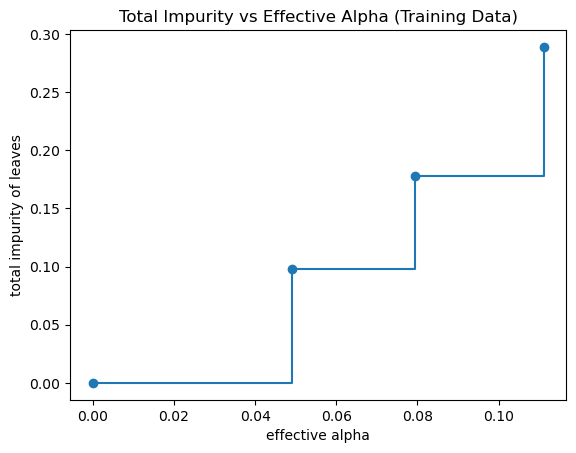

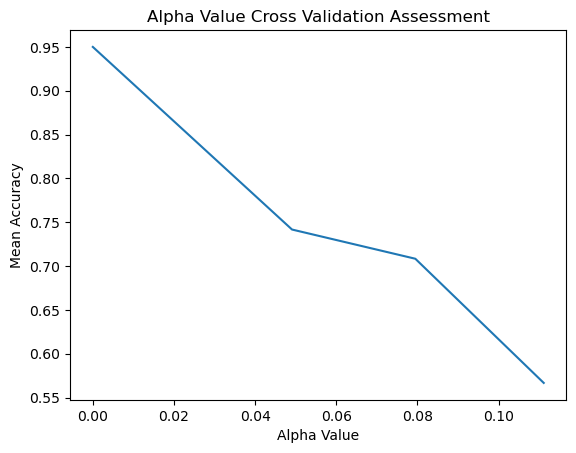

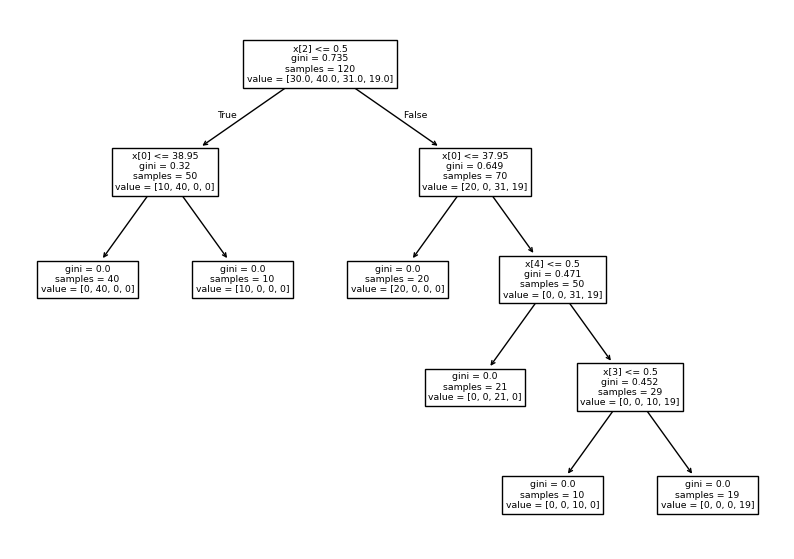

def tree(temp, nausea, lumbar pain, urine pushing, micturition pains, urethra pain):
  if lumbar pain <= 0.5:
    if temp <= 38.95000076293945:
      return [[0. 1. 0. 0.]]
    else:  # if temp > 38.95000076293945
      return [[1. 0. 0. 0.]]
  else:  # if lumbar pain > 0.5
    if temp <= 37.95000076293945:
      return [[1. 0. 0. 0.]]
    else:  # if temp > 37.95000076293945
      if micturition pains <= 0.5:
        return [[0. 0. 1. 0.]]
      else:  # if micturition pains > 0.5
        if urine pushing <= 0.5:
          return [[0. 0. 1. 0.]]
        else:  # if urine pushing > 0.5
          return [[0. 0. 0. 1.]]
LabelPowerset(classifier=DecisionTreeClassifier(random_state=0),
              require_dense=[True, True])


In [5]:
# cost complexity pruning - weakest link pruning
# used to grow a large tree T0 and then prune it back in order to obtain a subtree

def cost_complexity_pruning(df, x_vars, labels):
    # ID X and y vars and converty to numpy array
    X_train = df[x_vars].to_numpy()
    y_train = df[labels].to_numpy()

    # train raw tree
    raw_tree = DecisionTreeClassifier(random_state=0)
    raw_tree.fit(X_train, y_train)

    path = raw_tree.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    # train trees using the effective alphas
    # cross validate to find best alpha
    clfs = []
    for ccp_alpha in ccp_alphas[:-1]:
        clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        clfs.append(scores.mean())

    # find index of the best score
    best_alpha_index = np.argmax(clfs)
    best_ccp_alpha = ccp_alphas[best_alpha_index]

    # train the final pruned tree using Label Powerset
    pruned_tree = DecisionTreeClassifier(random_state=0, ccp_alpha=best_ccp_alpha)
    clf = LabelPowerset(classifier=pruned_tree)
    clf.fit(X_train, y_train)

    print(f"Alpha Values Tested: {ccp_alphas}")
    print(f"Best Alpha: {best_ccp_alpha}")

    # plot impurity v. effective alpha
    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs Effective Alpha (Training Data)")
    plt.show()

    # plot alpha / accuracy score from cross validation
    plt.plot(ccp_alphas[:-1], clfs)
    plt.xlabel("Alpha Value")
    plt.ylabel("Mean Accuracy")
    plt.title("Alpha Value Cross Validation Assessment")
    plt.show()

    plt.figure(figsize=(10, 7))
    tree.plot_tree(clf.classifier)
    plt.show()

    tree_to_code(clf, tree_features)
    return clf


print(cost_complexity_pruning(diagnosis_df, tree_features, tree_labels))

## LASSO and Boosting for Regression

**Download the Communities and Crime data (3) from https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime. Use the first 1495 rows of data as the training set and the rest as the test set.**

In [5]:
communities_cols = [
    "state", "county", "community", "communityname", "fold", "population",
    "householdsize", "racepctblack", "racePctWhite", "racePctAsian", "racePctHisp",
    "agePct12t21", "agePct12t29", "agePct16t24", "agePct65up", "numbUrban",
    "pctUrban", "medIncome", "pctWWage", "pctWFarmSelf", "pctWInvInc", "pctWSocSec",
    "pctWPubAsst", "pctWRetire", "medFamInc", "perCapInc", "whitePerCap",
    "blackPerCap", "indianPerCap", "AsianPerCap", "OtherPerCap", "HispPerCap",
    "NumUnderPov", "PctPopUnderPov", "PctLess9thGrade", "PctNotHSGrad", "PctBSorMore",
    "PctUnemployed", "PctEmploy", "PctEmplManu", "PctEmplProfServ", "PctOccupManu",
    "PctOccupMgmtProf", "MalePctDivorce", "MalePctNevMarr", "FemalePctDiv",
    "TotalPctDiv", "PersPerFam", "PctFam2Par", "PctKids2Par", "PctYoungKids2Par",
    "PctTeen2Par", "PctWorkMomYoungKids", "PctWorkMom", "NumIlleg", "PctIlleg",
    "NumImmig", "PctImmigRecent", "PctImmigRec5", "PctImmigRec8", "PctImmigRec10",
    "PctRecentImmig", "PctRecImmig5", "PctRecImmig8", "PctRecImmig10",
    "PctSpeakEnglOnly", "PctNotSpeakEnglWell", "PctLargHouseFam", "PctLargHouseOccup",
    "PersPerOccupHous", "PersPerOwnOccHous", "PersPerRentOccHous", "PctPersOwnOccup",
    "PctPersDenseHous", "PctHousLess3BR", "MedNumBR", "HousVacant", "PctHousOccup",
    "PctHousOwnOcc", "PctVacantBoarded", "PctVacMore6Mos", "MedYrHousBuilt",
    "PctHousNoPhone", "PctWOFullPlumb", "OwnOccLowQuart", "OwnOccMedVal",
    "OwnOccHiQuart", "RentLowQ", "RentMedian", "RentHighQ", "MedRent",
    "MedRentPctHousInc", "MedOwnCostPctInc", "MedOwnCostPctIncNoMtg", "NumInShelters",
    "NumStreet", "PctForeignBorn", "PctBornSameState", "PctSameHouse85",
    "PctSameCity85", "PctSameState85", "LemasSwornFT", "LemasSwFTPerPop",
    "LemasSwFTFieldOps", "LemasSwFTFieldPerPop", "LemasTotalReq", "LemasTotReqPerPop",
    "PolicReqPerOffic", "PolicPerPop", "RacialMatchCommPol", "PctPolicWhite",
    "PctPolicBlack", "PctPolicHisp", "PctPolicAsian", "PctPolicMinor",
    "OfficAssgnDrugUnits", "NumKindsDrugsSeiz", "PolicAveOTWorked", "LandArea",
    "PopDens", "PctUsePubTrans", "PolicCars", "PolicOperBudg", "LemasPctPolicOnPatr",
    "LemasGangUnitDeploy", "LemasPctOfficDrugUn", "PolicBudgPerPop", "ViolentCrimesPerPop"
]

# create df and split training / test data
communities_df = pd.read_csv("data/communities.data", names=communities_cols)

# drop non predictive cols
non_predictive_cols = ["state", "county", "community", "communityname", "fold"]
communities_df.drop(columns=non_predictive_cols, inplace=True)

# make list of predictive cols (x vars) to use in the future
X_vars = [col for col in communities_cols if col not in non_predictive_cols + ["ViolentCrimesPerPop"]]
y_var = "ViolentCrimesPerPop"

In [8]:
# check for missing data
communities_df.replace("?", np.nan, inplace=True)
missing_percent = communities_df.isna().mean() * 100
print("Missing data from communities_df before imputation")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))

Missing data from communities_df before imputation
PctPolicBlack           84.002006
PctPolicHisp            84.002006
LemasGangUnitDeploy     84.002006
LemasPctPolicOnPatr     84.002006
PolicOperBudg           84.002006
PolicCars               84.002006
PolicAveOTWorked        84.002006
NumKindsDrugsSeiz       84.002006
OfficAssgnDrugUnits     84.002006
PctPolicMinor           84.002006
PctPolicAsian           84.002006
PolicBudgPerPop         84.002006
LemasSwornFT            84.002006
PctPolicWhite           84.002006
RacialMatchCommPol      84.002006
PolicPerPop             84.002006
PolicReqPerOffic        84.002006
LemasTotReqPerPop       84.002006
LemasTotalReq           84.002006
LemasSwFTFieldPerPop    84.002006
LemasSwFTFieldOps       84.002006
LemasSwFTPerPop         84.002006
OtherPerCap              0.050150
dtype: float64


In [ ]:
# handling missing data

#imputation
# impute cols with low missing data using median - OtherPerCap has 5.0150% missing data
# use median bc mean is sometimes biased towards outliers
communities_df["OtherPerCap"] = communities_df["OtherPerCap"].astype(float)
communities_df["OtherPerCap"] = communities_df["OtherPerCap"].fillna(communities_df["OtherPerCap"].median())

# other cols have very high amounts of missing data (84%) bc those communities are missing LEMAS survey
# per limitations, LEMAS survey was completed by police departments with at least 100 officers, plus a random sample of smaller departments
# many communities are missing LEMAS data -- mostly smaller, maybe rural depts
# because the other data is mostly for larger depts, mean or median would not be appropriate here
# chose to use Iterative Imputer bc missing variables are correlated with each other (dept size / supplies / etc.)

cols_missing_data = [
    "LemasSwornFT",
    "LemasSwFTPerPop",
    "LemasGangUnitDeploy",
    "LemasPctPolicOnPatr",
    "PolicOperBudg",
    "PolicCars",
    "PolicAveOTWorked",
    "NumKindsDrugsSeiz",
    "OfficAssgnDrugUnits",
    "PctPolicMinor",
    "PctPolicAsian",
    "PctPolicHisp",
    "PctPolicBlack",
    "PctPolicWhite",
    "RacialMatchCommPol",
    "PolicPerPop",
    "PolicReqPerOffic",
    "LemasTotReqPerPop",
    "LemasTotalReq",
    "LemasSwFTFieldPerPop",
    "LemasSwFTFieldOps",
    "PolicBudgPerPop"
]

# imputing missing values by modeling each feature with missing values as a function of other features
# "uses info from multiple columns to predict what the missing data should be, resulting in more accurate and reliable imputation"
imputer = IterativeImputer(random_state=0, max_iter=50)
communities_df[X_vars] = imputer.fit_transform(communities_df[X_vars])

# re check for missing values - now this should be empty bc all missing data had been handled through imputation
missing_percent = communities_df.isna().mean() * 100
print("Missing data from communities_df after imputation")
print(missing_percent[missing_percent > 0].sort_values(ascending=False))


Missing data from communities_df after imputation
Series([], dtype: float64)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [10]:
# split train / test data
def split_community_data(df):
    train_df = df.iloc[:1495]
    test_df = df.iloc[1495:]

    return train_df, test_df

# split df in dfs with x vars and y var
def get_x_y_vars(df, X_vars):
    x_df = df[X_vars]
    y_df = df["ViolentCrimesPerPop"]

    return x_df, y_df

train_df, test_df = split_community_data(communities_df)

### Plot a correlation matrix

                     population  householdsize  racepctblack  racePctWhite  \
population             1.000000      -0.046148      0.231178     -0.300845   
householdsize         -0.046148       1.000000     -0.067109     -0.235907   
racepctblack           0.231178      -0.067109      1.000000     -0.794389   
racePctWhite          -0.300845      -0.235907     -0.794389      1.000000   
racePctAsian           0.181603       0.201996     -0.106738     -0.270266   
...                         ...            ...           ...           ...   
LemasPctPolicOnPatr   -0.172233      -0.107642     -0.171903      0.238717   
LemasGangUnitDeploy    0.113969       0.023267      0.113004     -0.222683   
LemasPctOfficDrugUn    0.466352      -0.094368      0.260793     -0.276234   
PolicBudgPerPop       -0.060564       0.025336     -0.139881      0.051182   
ViolentCrimesPerPop    0.367157      -0.034923      0.631264     -0.684770   

                     racePctAsian  racePctHisp  agePct12t21  ag

<Figure size 1600x1100 with 0 Axes>

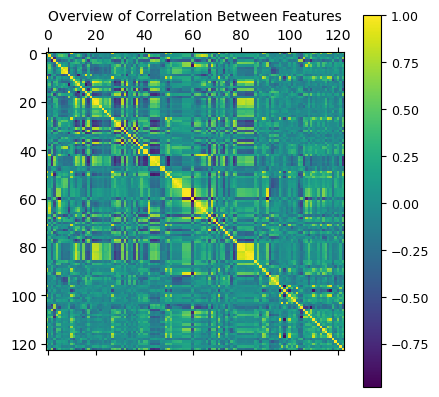

In [ ]:
# correlation matrix of all features
correlation_matrix_all_feats = communities_df.corr()
print(correlation_matrix_all_feats)

# vague overview visualization of correlation between features
# as we can see, lots of teal and blue on our graph (correlation of 0.5 to -0.5) w/ some yellow and purple
plt.figure(figsize=(16,11))
plt.matshow(communities_df.corr())
cb = plt.colorbar()
cb.ax.tick_params(labelsize=9)
plt.title('Overview of Correlation Between Features', fontsize=10);
plt.show()


### Calculate the Coefficient of Variation CV

In [ ]:
# std is sensitive to the scale of the data, CV is unitless (allows direct comparison of variability)
# higher absolute vals represent greater degree of relative variability - can be useful for feature selection
# features that have low variabliltiy (ex. 1,1,1,1, etc) have little to no predictive power
def get_coeff_of_variation(df):
    feat_cvs = []
    for feature in X_vars:
        feat_s = df[feature].std()
        feat_m = df[feature].mean()

        feat_cv = feat_s / feat_m
        feat_cvs.append([feature, feat_cv, abs(feat_cv)])
    
    cv_df = pd.DataFrame(feat_cvs, columns=["feature", "CV", "Absolute CV"]) # used source 4
    sorted_cv_df = cv_df.sort_values(by='Absolute CV', ascending=False).reset_index(drop=True)

    return sorted_cv_df

feat_cv_df = get_coeff_of_variation(communities_df)
print(feat_cv_df)

                feature         CV  Absolute CV
0         LemasTotalReq -11.906212    11.906212
1         PolicOperBudg  10.958646    10.958646
2          LemasSwornFT  -7.807051     7.807051
3             NumStreet   4.407702     4.407702
4         NumInShelters   3.485481     3.485481
..                  ...        ...          ...
117        PctHousOccup   0.269647     0.269647
118       PctPolicWhite   0.237701     0.237701
119  RacialMatchCommPol   0.232356     0.232356
120   NumKindsDrugsSeiz   0.181662     0.181662
121   LemasSwFTFieldOps   0.084005     0.084005

[122 rows x 3 columns]


### Scatter plots and box plots for highest CV features

**Significance of [√128] features with highest CV:** The coefficient of variation is a relative measure of variability that indicates the size of a standard deviation in relation to its mean. Standard deviation is sensitive to the scale of the data, but because CV is unitless, it allows us to make a direct comparison of variability between all features. From the scatterplots, we can see that the plots are very spread out and diverse, with lots of points throughout the plot. This is a good thing because it means that these features have more predictive power when creating a model. When you take the absolute value of a CV, features with a higher value represent greater degree of relative variability, which can be useful for feature selection. Features that have low variablility (ex. 1,1,1,1,...), have little to no predictive power because it doesn't give our model any helpful insight.

Top Feats: ['LemasTotalReq', 'PolicOperBudg', 'LemasSwornFT', 'NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'PctPolicAsian', 'NumUnderPov', 'PolicCars']


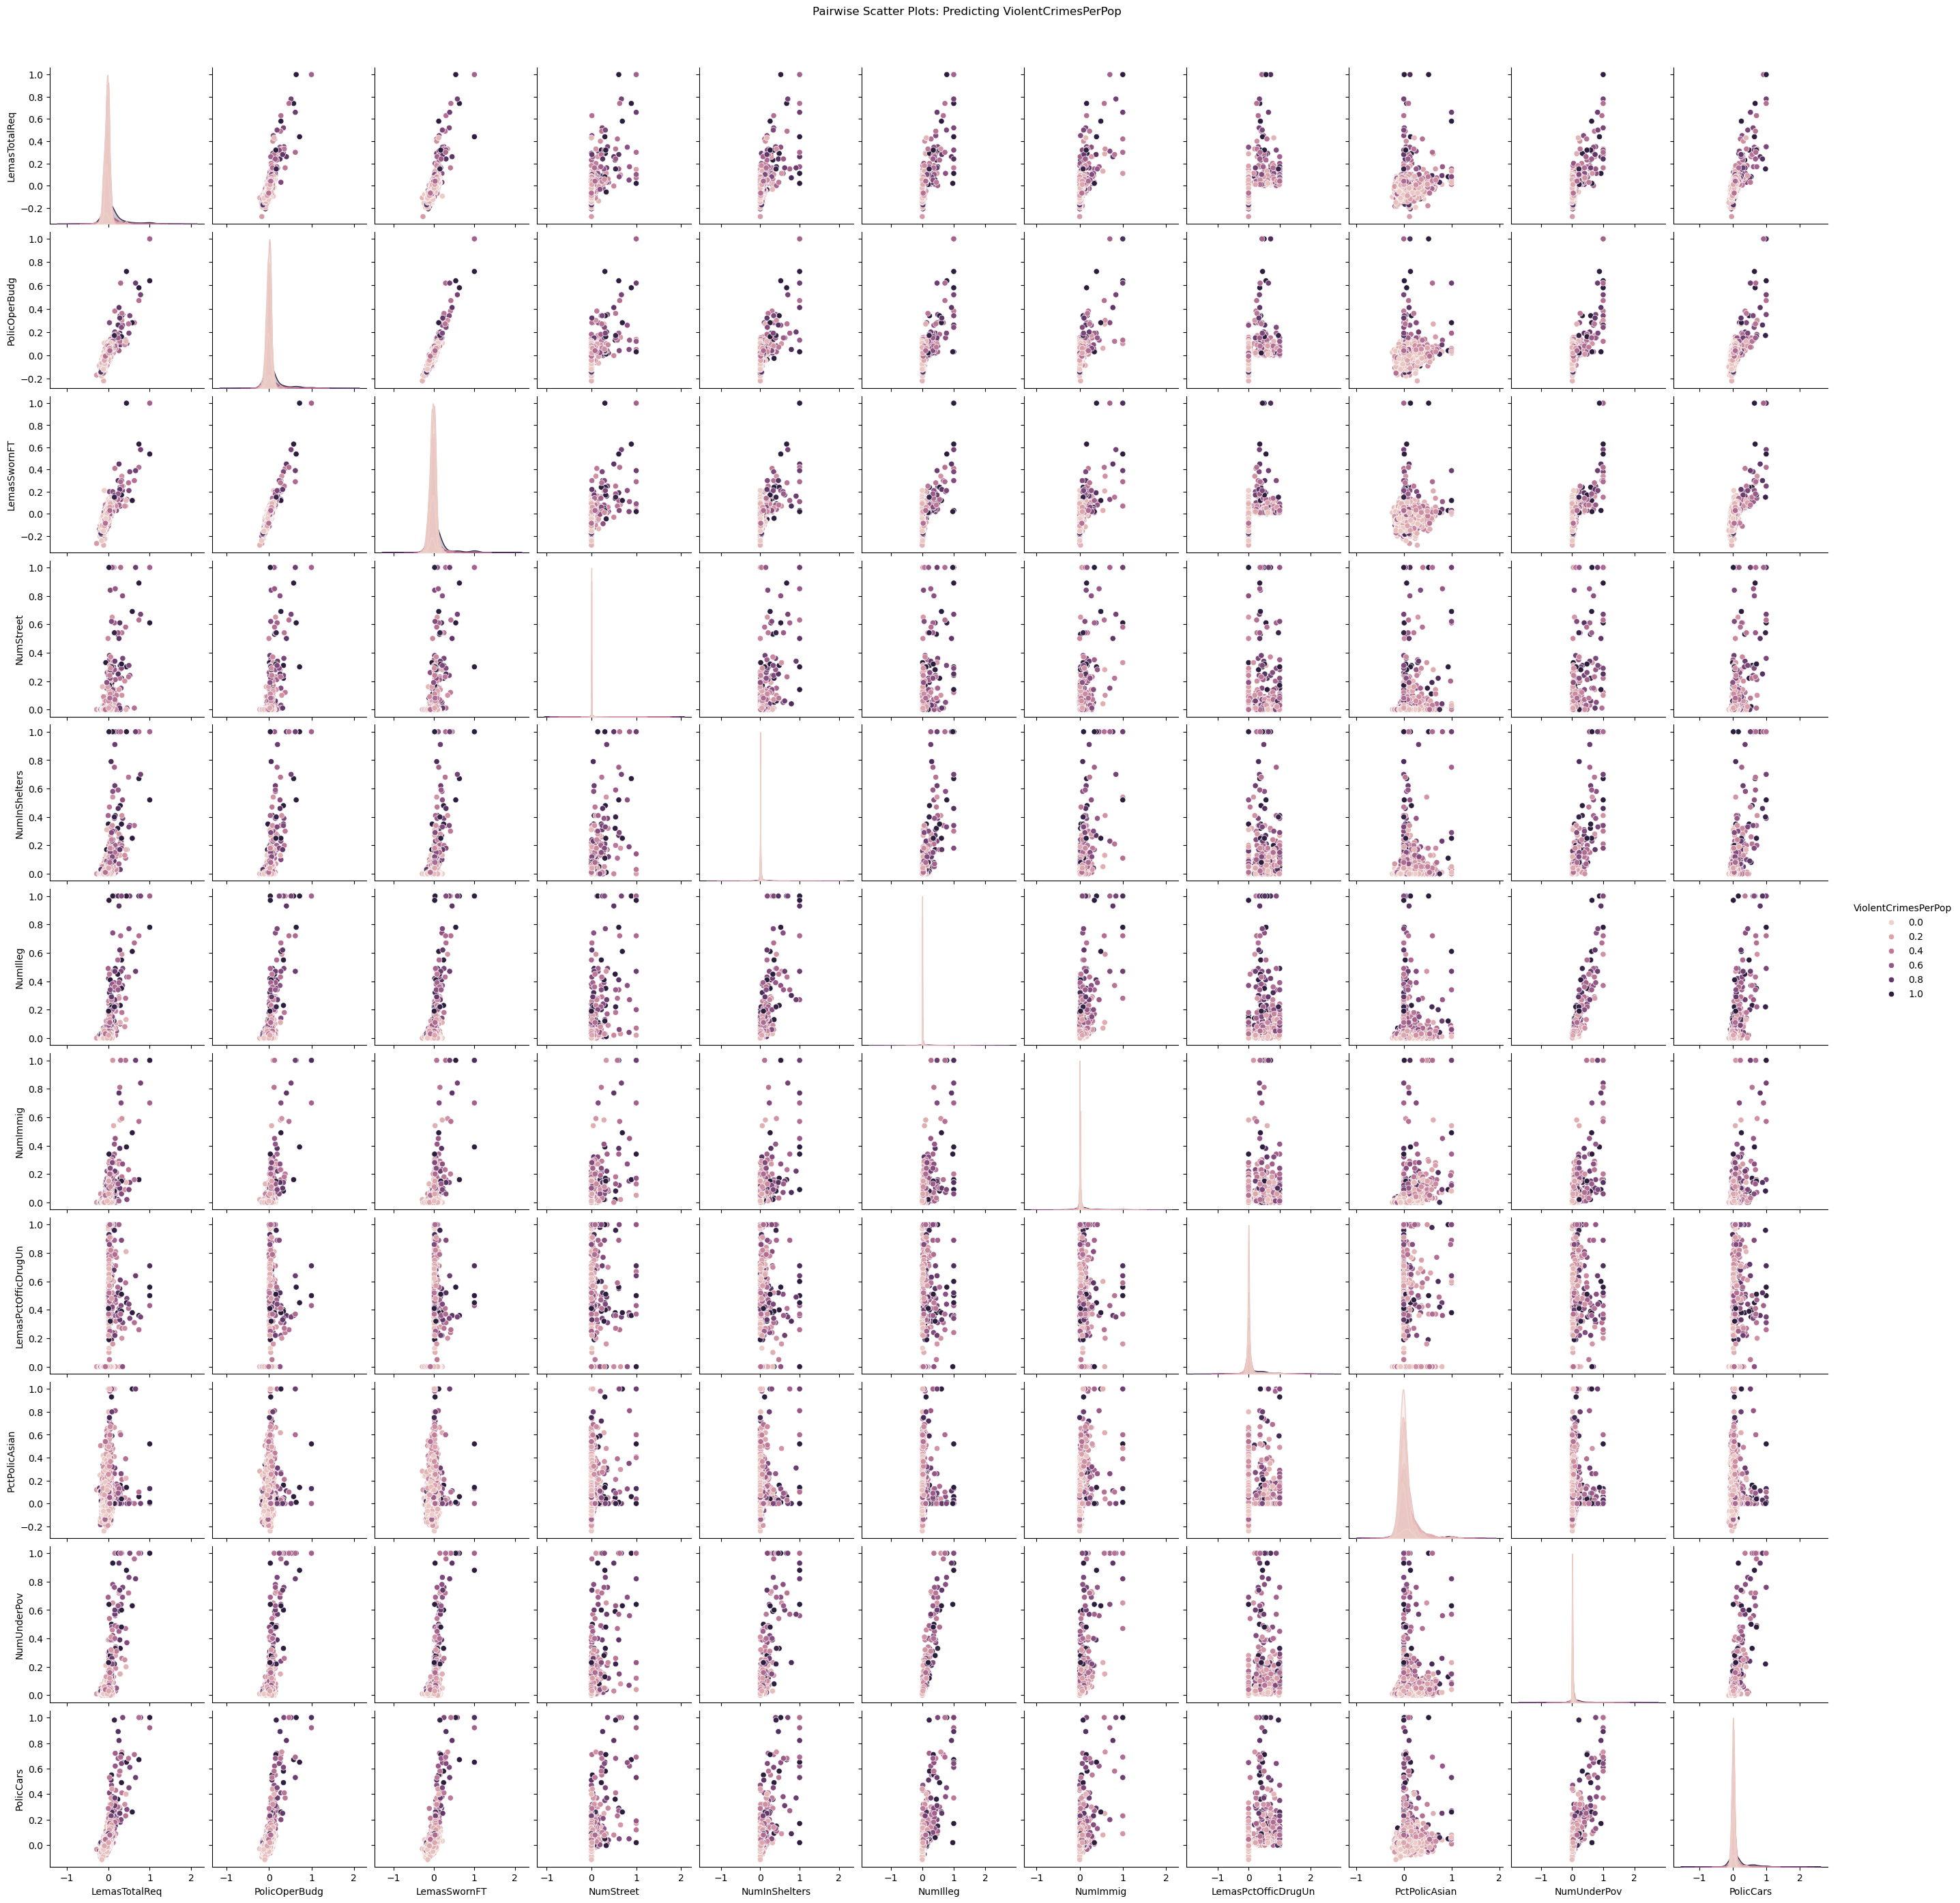

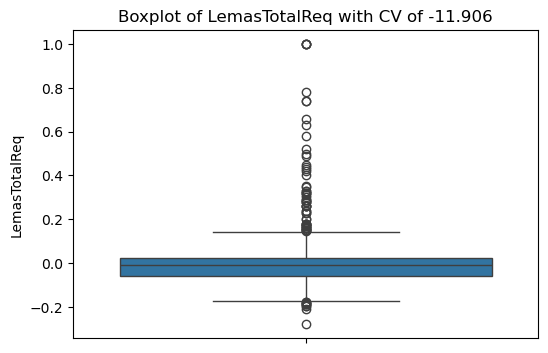

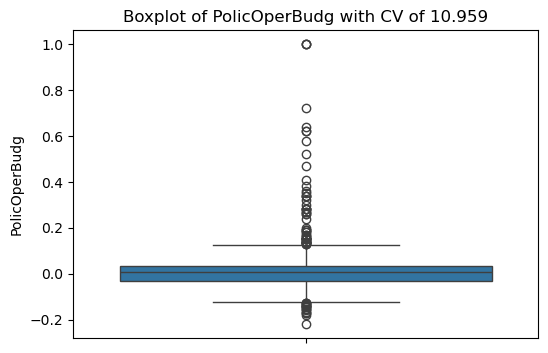

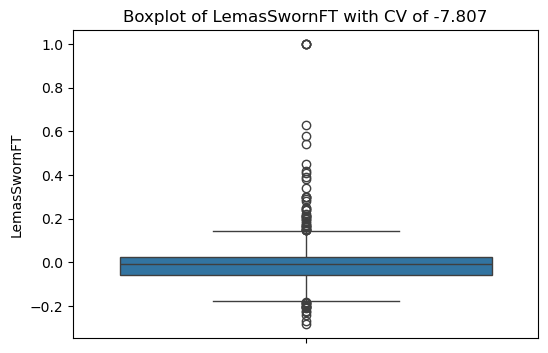

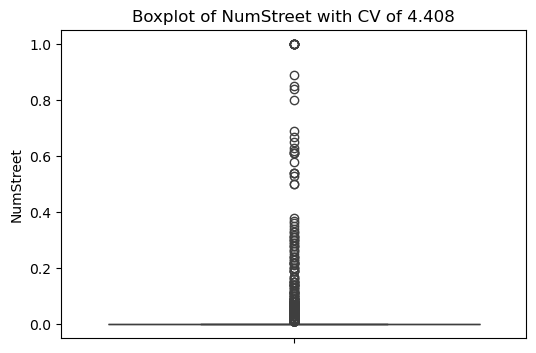

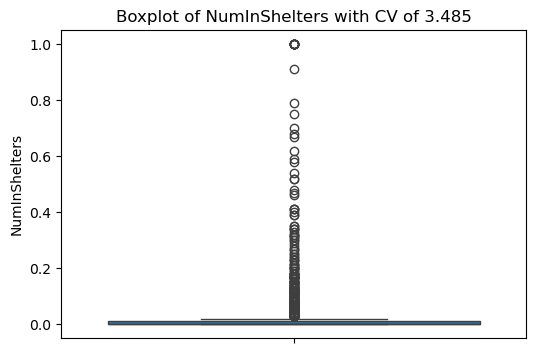

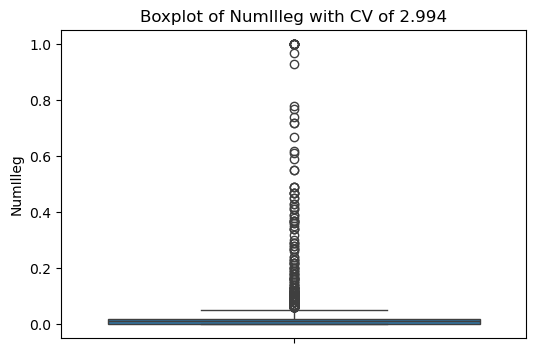

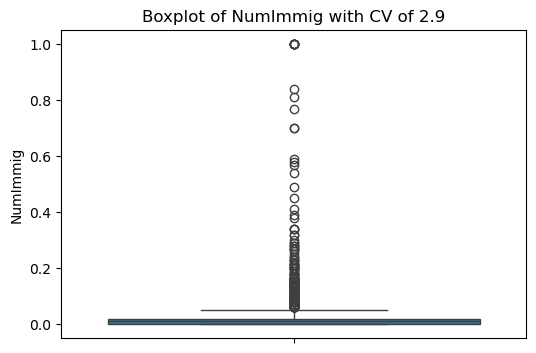

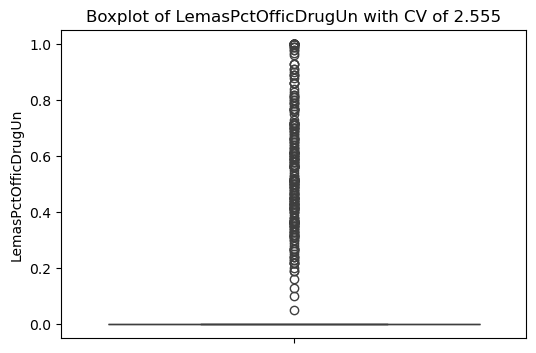

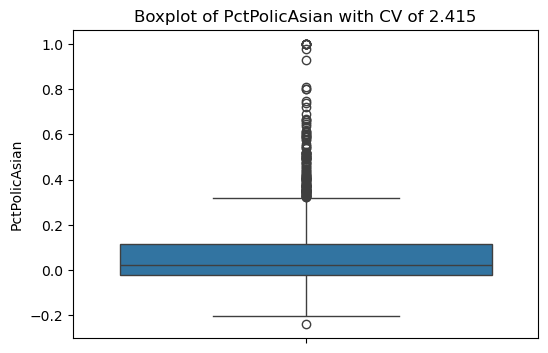

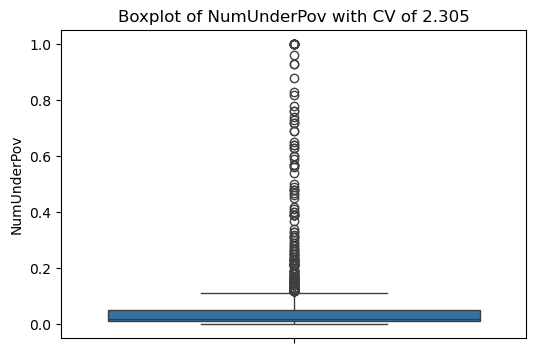

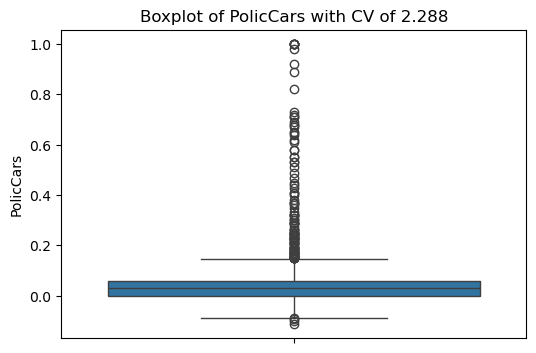

None


In [12]:
# get feats with the highest CV
num_feats = int(np.sqrt(128))
top_feats = feat_cv_df[:num_feats]["feature"].to_list()
print(f"Top Feats: {top_feats}")

# top feats + independent variable df
top_feats_cols = top_feats + ["ViolentCrimesPerPop"]
top_feats_df = communities_df[top_feats_cols]

# make scatterplots for top features
def top_feat_pairplots(feats: list, df):

    # create pairplot with ViolentCrimesPerPop as hue
    sns.pairplot(df, hue="ViolentCrimesPerPop")
    plt.suptitle("Pairwise Scatter Plots: Predicting ViolentCrimesPerPop", y=1.02)
    plt.show()


    # create boxplots for each feature
    for feat in feats:
        cv_val = round(feat_cv_df.loc[feat_cv_df["feature"] == feat, "CV"].values[0], 3)
        plt.figure(figsize=(6, 4))
        sns.boxplot(y=df[feat])
        plt.title(f"Boxplot of {feat} with CV of {cv_val}")
        plt.show()

print(top_feat_pairplots(top_feats, top_feats_df))
train_df_top_feats, test_df_top_feats = split_community_data(top_feats_df)

### Fit a linear model Using least squares

In [13]:
# list of model description, mse, r2 for the following models
# will turn this into a df to compare models

model_assessment_all = []
model_assessment_top = []

In [14]:
def fit_LR_model(df, X_vars):
    # prep data
    train_df, test_df = split_community_data(df)
    X_train, y_train = get_x_y_vars(train_df, X_vars)
    X_test, y_test = get_x_y_vars(test_df, X_vars)

    # fit model using least squares
    model = LinearRegression()
    model.fit(X_train, y_train)

    # make predictions on the test data + report MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    return mse, r2

LR_all_mse, LR_all_r2 = fit_LR_model(communities_df, X_vars)
print(f"LR w/ All Feats-- MSE: {LR_all_mse}, R2: {LR_all_r2}")
model_assessment_all.append(["LR w/ All Feats", LR_all_mse, LR_all_r2])

LR_top_mse, LR_top_r2 = fit_LR_model(top_feats_df, top_feats)
print(f"LR w/ Top Coefficient of Variation Feats -- MSE: {LR_top_mse}, R2: {LR_top_r2}")
model_assessment_top.append(["LR w/ Top CV Feats", LR_top_mse, LR_top_r2])

LR w/ All Feats-- MSE: 0.018075565587794367, R2: 0.6199042931721106
LR w/ Top Coefficient of Variation Feats -- MSE: 0.030482532479363056, R2: 0.3590087307436012


### Fit a ridge regression model with λ chosen by cross-validation

ridge regression


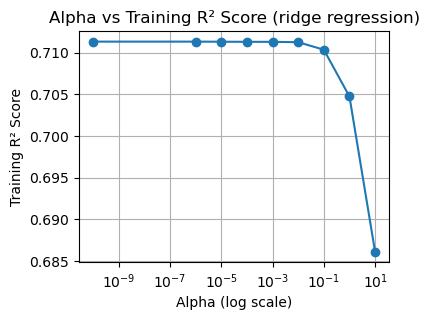

Selected Alpha (first value with near-max R Squared): 0.01
Ridge w/ All Feats-- MSE: 0.01815678363860827, R2: 0.6181964278064958
ridge regression


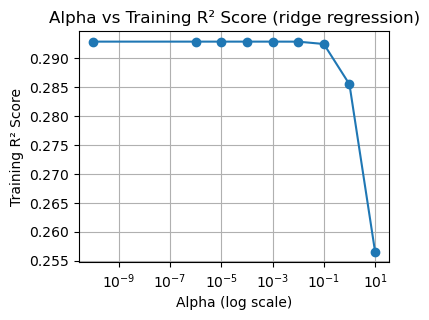

Selected Alpha (first value with near-max R Squared): 0.01
Ridge w/ Top Coefficient of Variation Feats -- MSE: 0.030481965427738993, R2: 0.35902065479028233


In [ ]:
def fit_regularization_model(df, X_vars, model_type):
    # prep data
    model_type = model_type.lower()
    train_df, test_df = split_community_data(df)
    X_train, y_train = get_x_y_vars(train_df, X_vars)
    X_test, y_test = get_x_y_vars(test_df, X_vars)

    # create and train a Ridge or Lasso Regression model
    # find best alpha using cross validation
    alpha_list = [1e-10, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e+1]
    train_scores = []

    # plot alpha v training score
    # train model for each alpha and record R squared
    for alpha in alpha_list:
        # select model
        if model_type == "lasso":
            model = Lasso(alpha=alpha, max_iter=1000000)
        elif model_type == "ridge":
            model = Ridge(alpha=alpha)
        model.fit(X_train, y_train)
        score = model.score(X_train, y_train)
        train_scores.append(score)

    print("\033[31m" + model_type + " regression" + "\033[0m")
    plt.figure(figsize=(4, 3))
    plt.plot(alpha_list, train_scores, marker='o')
    plt.xscale('log')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Training R² Score')
    plt.title(f"Alpha vs Training R² Score ({model_type} regression)")
    plt.grid(True)
    plt.show()

    # bias variance tradeoff - R squared seems to flatline so I picked the best alpha after which the R2 doesnt improve greatly
    # otherwise best alpha is all the features, which may not be ideal due bias variance tradeoff
    # goal is to find the last alpha before the big drop of differences bwtn R2 - to simplify the model
    r2_diffs = np.diff(train_scores)
    elbow_a_index = next(i for i, diff in enumerate(r2_diffs) if abs(diff) > 0.0001)
    elbow_a = alpha_list[elbow_a_index]
    
    if model_type == "lasso":
        clf = Lasso(alpha=elbow_a, max_iter=1000000)
    elif model_type == "ridge":
        clf = Ridge(alpha=elbow_a)

    # use cross validation to find the best alpha
    clf.fit(X_train, y_train)
    clf.score(X_train, y_train)
    
    # make predictions on the test data + report MSE
    y_pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # return features used if lasso
    if model_type == "lasso":
        print(f"Number of Features Provided During Training: {len(X_vars)}")
        coef_df = pd.DataFrame({
            "feature": X_vars,
            "coefficient": clf.coef_
        })
        features_used_df = coef_df[coef_df['coefficient'] != 0.0]
        feature_list = features_used_df["feature"].tolist()
        print(f"Number of Features Used in Final Model: {len(feature_list)}")
        print(f"Features Used: {feature_list}")

        
    print(f"Selected Alpha (first value with near-max R Squared): {elbow_a}")

    return mse, r2, elbow_a

ridge_all_mse, ridge_all_r2, ridge_all_a = fit_regularization_model(communities_df, X_vars, 'ridge')
print(f"Ridge w/ All Feats-- MSE: {ridge_all_mse}, R2: {ridge_all_r2}")
model_assessment_all.append([f"Ridge w/ All Feats - alpha {ridge_all_a}", ridge_all_mse, ridge_all_r2])

ridge_top_mse, ridge_top_r2, ridge_top_a = fit_regularization_model(top_feats_df, top_feats, 'ridge')
print(f"Ridge w/ Top Coefficient of Variation Feats -- MSE: {ridge_top_mse}, R2: {ridge_top_r2}")
model_assessment_top.append([f"Ridge w/ All Feats - alpha {ridge_top_a}", ridge_top_mse, ridge_top_r2])


### Fit a LASSO model with λ chosen by cross-validation

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.205e+01, tolerance: 8.441e-03
  model = cd_fast.enet_coordinate_descent(


lasso regression


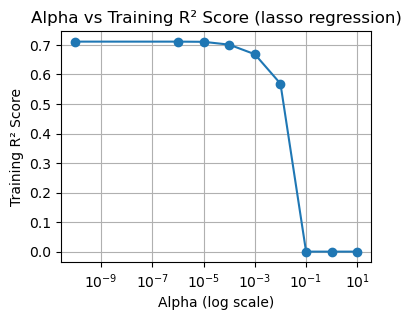

Number of Features Provided During Training: 122
Number of Features Used in Final Model: 121
Features Used: ['population', 'householdsize', 'racepctblack', 'racePctWhite', 'racePctAsian', 'racePctHisp', 'agePct12t21', 'agePct12t29', 'agePct16t24', 'agePct65up', 'numbUrban', 'pctUrban', 'medIncome', 'pctWWage', 'pctWFarmSelf', 'pctWInvInc', 'pctWSocSec', 'pctWPubAsst', 'pctWRetire', 'medFamInc', 'perCapInc', 'whitePerCap', 'blackPerCap', 'indianPerCap', 'AsianPerCap', 'OtherPerCap', 'HispPerCap', 'NumUnderPov', 'PctPopUnderPov', 'PctLess9thGrade', 'PctNotHSGrad', 'PctBSorMore', 'PctUnemployed', 'PctEmploy', 'PctEmplManu', 'PctEmplProfServ', 'PctOccupManu', 'PctOccupMgmtProf', 'MalePctDivorce', 'MalePctNevMarr', 'FemalePctDiv', 'TotalPctDiv', 'PersPerFam', 'PctFam2Par', 'PctKids2Par', 'PctYoungKids2Par', 'PctTeen2Par', 'PctWorkMomYoungKids', 'PctWorkMom', 'NumIlleg', 'PctIlleg', 'NumImmig', 'PctImmigRecent', 'PctImmigRec5', 'PctImmigRec8', 'PctImmigRec10', 'PctRecentImmig', 'PctRecImmig5

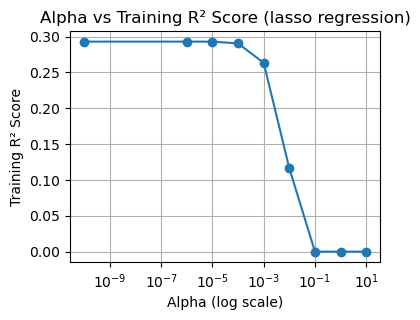

Number of Features Provided During Training: 11
Number of Features Used in Final Model: 11
Features Used: ['LemasTotalReq', 'PolicOperBudg', 'LemasSwornFT', 'NumStreet', 'NumInShelters', 'NumIlleg', 'NumImmig', 'LemasPctOfficDrugUn', 'PctPolicAsian', 'NumUnderPov', 'PolicCars']
Selected Alpha (first value with near-max R Squared): 1e-05
Lasso w/ Top Coefficient of Variation Feats -- MSE: 0.030478187327797036, R2: 0.35910010124306024


In [16]:
# data already normalized in the dataset
lasso_all_mse, lasso_all_r2, lasso_all_a = fit_regularization_model(communities_df, X_vars, 'lasso')
print(f"Lasso w/ All Feats-- MSE: {lasso_all_mse}, R2: {lasso_all_r2}")
model_assessment_all.append([f"Lasso w/ All Feats - alpha {lasso_all_a}", lasso_all_mse, lasso_all_r2])

lasso_top_mse, lasso_top_r2, lasso_top_a = fit_regularization_model(top_feats_df, top_feats, 'lasso')
print(f"Lasso w/ Top Coefficient of Variation Feats -- MSE: {lasso_top_mse}, R2: {lasso_top_r2}")
model_assessment_top.append([f"Lasso w/ All Feats - alpha {lasso_top_a}", lasso_top_mse, lasso_top_r2])

### (i) Fit a PCR model with M (the number of principal components) chosen by cross-validation

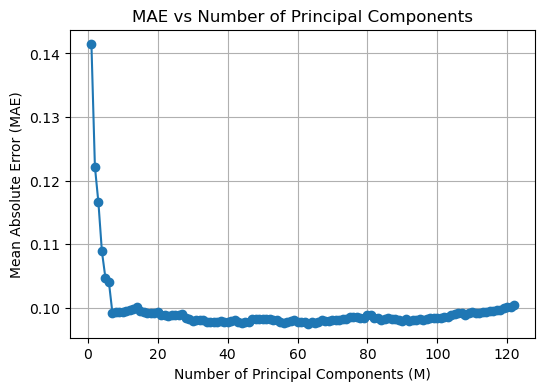

Selected M (first value with near-min MAE): 28
PCA w/ All Feats-- MSE: 0.018075565587794443, R2: 0.619904293172109


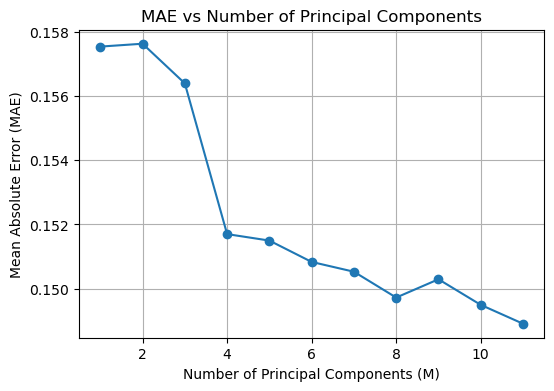

Selected M (first value with near-min MAE): 8
PCA w/ Top Coefficient of Variation Feats -- MSE: 0.030482532479363052, R2: 0.3590087307436013


In [ ]:
# pca - unsupervised dimensionality reduction technique that transforms a set of possibly correlated variables into a set of linearly uncorrelated variables called principal components
# components are ordered by the amount of variance they explain in the data
# number of components (M) to retain determined through cross-validation

# pcr in sklearn uses two components
# 1. instantiate and fit a PCA object to your predictor variables (features) & transform features into their principal components
# 2. use linear regression using these principal components as predictors rather than the original correlated variables

def fit_pcr_model(df, X_vars):
    # prep data
    train_df, test_df = split_community_data(df)
    X_train, y_train = get_x_y_vars(train_df, X_vars)
    X_test, y_test = get_x_y_vars(test_df, X_vars)

    # Create a pipeline to chain PCA and Linear Regression
    pca = PCA() 
    linear_regression = LinearRegression()
    pcr_model = Pipeline([('pca', pca), ('linear_regression', linear_regression)])

    # pca using grid search cross validation to find the most optimal M
    # why use neg MAE as CV score? gridsearch expects higher vals to be better, but mse is a loss function
    # used mae in cross validation assessment to get balanced error evaluation, mae not as sensitive to outliers as mse
    param_grid = {'pca__n_components': range(1, len(X_vars) + 1)} # gives range of feature values to assign as M
    k_fold_cv_strategy = KFold(n_splits=5, shuffle=True, random_state=13)
    grid_search = GridSearchCV(pcr_model, param_grid, cv=k_fold_cv_strategy, scoring='neg_mean_absolute_error')

    # fit GridSearchCV to find the best M and model
    grid_search.fit(X_train, y_train)

    # plot MAE v. M
    mae_scores = -grid_search.cv_results_['mean_test_score'] 
    components = param_grid['pca__n_components']

    plt.figure(figsize=(6, 4))
    plt.plot(components, mae_scores, marker='o')
    plt.xlabel('Number of Principal Components (M)')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.title('MAE vs Number of Principal Components')
    plt.grid(True)
    plt.show()

    # bias variance tradeoff - MAE seems to flatline so I picked the best M after which the MAE doesnt improve greatly
    # otherwise best M is all the features, which may not be ideal due bias variance tradeoff
    # goal is to find the first "elbow point" in the data
    min_mae = min(mae_scores)
    threshold = min_mae + 0.001
    elbow_M = next(i+1 for i, val in enumerate(mae_scores) if val <= threshold)

    # set PCA to chosen M and fit linear regression model
    pca = PCA(n_components=elbow_M)
    linear_regression = LinearRegression()
    pcr_model.fit(X_train, y_train)

    # make predictions on the test data + report MSE
    y_pred = pcr_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
        
    print(f"Selected M (first value with near-min MAE): {elbow_M}")
    return mse, r2, elbow_M

# print(f"MSE for LR w/ All Feats-- {fit_pcr_model(communities_df, X_vars)}")
# print(f"MSE for LR w/ Top Coefficient of Variation Feats -- {fit_pcr_model(top_feats_df, top_feats)}")
pca_all_mse, pca_all_r2, pca_all_m = fit_pcr_model(communities_df, X_vars)
print(f"PCA w/ All Feats-- MSE: {pca_all_mse}, R2: {pca_all_r2}")
model_assessment_all.append([f"PCA w/ All Feats - M {pca_all_m}", pca_all_mse, pca_all_r2])

pca_top_mse, pca_top_r2, pca_top_m = fit_pcr_model(top_feats_df, top_feats)
print(f"PCA w/ Top Coefficient of Variation Feats -- MSE: {pca_top_mse}, R2: {pca_top_r2}")
model_assessment_top.append([f"PCA w/ All Feats - M {pca_top_m}", pca_top_mse, pca_top_r2])

### (j) Fit a boosting tree


In [ ]:
# L1 penalized gradient boosting tree
# XGBoost used to create an ensemble of decision trees

def fit_boosting_tree(df, X_vars):
    # prep data
    train_df, test_df = split_community_data(df)
    X_train, y_train = get_x_y_vars(train_df, X_vars)
    X_test, y_test = get_x_y_vars(test_df, X_vars)

    # use grid search to find optimal regularization strength
    param_grid = {
        'reg_alpha': [.0001, .001, .1, 0.5, 1, 5, 10],
        'n_estimators': range(10,100,10),
        'max_depth': [3, 5, 7]
    }

    xgb = XGBRegressor(objective='reg:squarederror', random_state=13)

    grid_search = GridSearchCV(
        estimator=xgb,
        param_grid=param_grid,
        scoring=['r2', 'neg_mean_squared_error'],
        refit='r2',
        cv=5,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    best_alpha = grid_search.best_params_['reg_alpha']
    best_n = grid_search.best_params_['n_estimators']
    best_depth = grid_search.best_params_['max_depth']

    print("MSE:", mse)
    print("R²:", r2)
    print("Best alpha:", best_alpha)
    print("Best N Estimators:", best_n)
    print("Max Depth:", best_depth)

    # get most important features from final trained model
    importances = best_model.feature_importances_
    importance_percents = [] # make importances into percentages
    for i in importances:
        i= round(i * 100, 3)
        importance_percents.append(f"{i}%")
    importance_df = pd.DataFrame({'feature': X_train.columns, 'importance': importance_percents})
    importance_df = importance_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
    print(importance_df)

    model_summary = f"Best Alpha: {best_alpha}, Best n: {best_n}, Best Depth: {best_depth}"

    return mse, r2, model_summary

# print(f"MSE for LR w/ All Feats-- {fit_boosting_tree(communities_df, X_vars)}")
# print(f"MSE for LR w/ Top Coefficient of Variation Feats -- {fit_boosting_tree(top_feats_df, top_feats)}")

xg_all_mse, xg_all_r2, xg_all_summ = fit_boosting_tree(communities_df, X_vars)
print(f"XGBoost w/ All Feats-- MSE: {xg_all_mse}, R2: {xg_all_r2}")
model_assessment_all.append([f"XG Boost w/ All Feats - M {xg_all_summ}", xg_all_mse, xg_all_r2])

xg_top_mse, xg_top_r2, xg_top_summ = fit_boosting_tree(top_feats_df, top_feats)
print(f"XG Boost w/ Top Coefficient of Variation Feats -- MSE: {xg_top_mse}, R2: {xg_top_r2}")
model_assessment_top.append([f"XG Boost w/ Top Feats - M {xg_top_summ}", xg_top_mse, xg_top_r2])

Fitting 5 folds for each of 189 candidates, totalling 945 fits


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


MSE: 0.016791688167667122
R²: 0.6469018603084415
Best alpha: 0.001
Best N Estimators: 20
Max Depth: 3
                feature importance
0            PctFam2Par     8.452%
1           PctKids2Par     7.879%
2              PctIlleg    39.171%
3    RacialMatchCommPol     3.145%
4       PctLargHouseFam     2.853%
..                  ...        ...
117         PctEmplManu       0.0%
118       PctUnemployed       0.0%
119    PctBornSameState       0.0%
120      PctSameHouse85       0.0%
121          population       0.0%

[122 rows x 2 columns]
XGBoost w/ All Feats-- MSE: 0.016791688167667122, R2: 0.6469018603084415
Fitting 5 folds for each of 189 candidates, totalling 945 fits
MSE: 0.023657898478297877
R²: 0.5025181590863657
Best alpha: 1
Best N Estimators: 30
Max Depth: 3
                feature importance
0           NumUnderPov     8.884%
1             NumStreet     6.454%
2              NumIlleg    58.116%
3         PolicOperBudg     5.565%
4         NumInShelters     4.404%
5   LemasP

/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [23]:
# final dfs to compare models
all_feats_models = pd.DataFrame(model_assessment_all, columns=["Best Model Summary", "MSE", "R Squared"])
print("All Features")
print(all_feats_models)

top_feats_models = pd.DataFrame(model_assessment_top, columns=["Best Model Summary", "MSE", "R Squared"])
print("Top Features Using Coefficient of Variation")
print(top_feats_models)

All Features
                                  Best Model Summary       MSE  R Squared
0                                    LR w/ All Feats  0.018076   0.619904
1                    Ridge w/ All Feats - alpha 0.01  0.018157   0.618196
2                   Lasso w/ All Feats - alpha 1e-06  0.018173   0.617861
3                            PCA w/ All Feats - M 28  0.018076   0.619904
4  XG Boost w/ All Feats - M Best Alpha: 0.001, B...  0.016792   0.646902
Top Features Using Coefficient of Variation
                                  Best Model Summary       MSE  R Squared
0                                 LR w/ Top CV Feats  0.030483   0.359009
1                    Ridge w/ All Feats - alpha 0.01  0.030482   0.359021
2                   Lasso w/ All Feats - alpha 1e-05  0.030478   0.359100
3                             PCA w/ All Feats - M 8  0.030483   0.359009
4  XG Boost w/ Top Feats - M Best Alpha: 1, Best ...  0.023658   0.502518


As we can see in the dataframes above, the model that had the best test MSE and R Squared was the XG Boost model. For both the model with all features and the top features attained by comparing CV values, the L1 penalized gradient boosting tree performed best. We can also see that the models with all features performed better than with only the top features.